# Setup

In [3]:
%%capture
!pip install datasets
!pip install mediapipe

In [4]:
from datasets import load_dataset
#mediapipe dependencies
import mediapipe as mp

#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import shutil
import os

### Utilities

In [ ]:
# Stringify a numeric label into textual form
def decode_label(label):
    if label == 1:
        return "rock"
    elif label == 0:
        return "paper"
    elif label == 2:
        return "scissors"
    elif label == 3:
        return "none"
    return None
    # return "rock" if label == 1 else "paper" if label == 0 else "scissors"

# grey scale images (channel 1)
def grey_scale():
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.Grayscale(num_output_channels=1),
  ])
  return transform

# returns a transformed image of shape (300, 300, 3)
def rgb_image_transform(image): # input type PIL.PngImagePlugin.PngImageFile
  resized_image = image.resize((300, 300))
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  return resized_image

# returns a numpy (tensor) of an image
def image_numpy(image):
  np_image = np.array(image)

  return np_image


In [ ]:
def add_col(ds, name):
    new_col = [None] * len(ds['train'])
    ds['train'] = ds['train'].add_column(name, new_col)
    new_col = [None] * len(ds['test'])
    ds['test'] = ds['test'].add_column(name, new_col)

In [ ]:
toImage = transforms.Compose([
    transforms.ToPILImage(),
])

In [ ]:
def reconstitute(npdata, num_components):
    global pca_4883
    pca = pca_4883
    val = np.dot(npdata[:num_components], pca.components_[:num_components]) # * std_dev + mean
    # val = val * std_dev + mean
    valn = np.clip(np.round(val * std_dev + mean), 0, 255).astype(np.uint8)
    # print(valn)
    img = toImage(valn.reshape((256, 256, 1)))
    return img


# Done

In [ ]:
prev_ds = load_dataset("conjunct/rps_dataset")

Generating train split:   0%|          | 0/9170 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
ds_v2 = load_dataset("conjunct/rps_raw")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9170 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
merged_ds = load_dataset("conjunct/rps_annotated")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
merged_jointly_ds = merged_ds

# MediaPipe port

In [ ]:
mp_drawing = mp.solutions.drawing_utils  # used to draw landmarks
mp_hands = mp.solutions.hands  # used to get landmarks from a photo

In [ ]:
add_col(ds_v2, 'annotated')
add_col(ds_v2, 'landmarks')

In [ ]:
ds_v2['train'][0]

{'raw': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300>,
 'label': 0,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300>,
 'src': 0,
 'annotated': None,
 'landmarks': None}

In [ ]:
#detection
from PIL import Image

def _hf_add_joints(batch):
    global hands
    # train
    joints = []
    landmarks = []

    for image in batch['image']:# CLEAN_DATA_URLS_TRAIN:
        image_np = image_numpy(image)
        try:
            results = hands.process(image_np)

            if results.multi_hand_landmarks:
                for num, hand in enumerate(results.multi_hand_landmarks): # loops however many hands are in the photo, hand is the landmarks, num is hand number
                    mp_drawing.draw_landmarks(image_np, hand, mp_hands.HAND_CONNECTIONS) # draw joints onto image

                # joint_url = os.path.join(joint_train_dir, 'data', filename)
                # landmark_url = os.path.join(joint_train_dir, 'label', filename)

                # Image.fromarray(image_np).save(joint_url, format='PNG')
                joints.append(Image.fromarray(image_np))

                # with open(landmark_url, 'w') as file:
                    # file.write(str(results.multi_hand_landmarks))

                landmarks.append(str(results.multi_hand_landmarks)) # str()
                # CLEAN_DATA_URLS_JOINT_TRAIN.append(joint_url)
                # CLEAN_DATA_URLS_LANDMARK_TRAIN.append(landmark_url)
            else:
                joints.append(None)
                landmarks.append(None)
        except Exception as e:
            print(f"error reading file or processing joint detection {e}")
            joints.append(None)
            landmarks.append(None)
    batch['annotated'] = joints
    batch['landmarks'] = landmarks
    return batch

with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:
    joint_ds = ds_v2.map(_hf_add_joints, batched=True, batch_size=32)

Parameter 'function'=<function _hf_add_joints at 0x7b727b78ad40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/9170 [00:00<?, ? examples/s]

Map:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
img_mode = joint_ds['train'].features['raw']

In [ ]:
# upload to hf
from datasets import Dataset
import datasets
from datasets import DatasetDict

joint_ds = joint_ds.cast_column("annotated", img_mode)
merged_ds = joint_ds

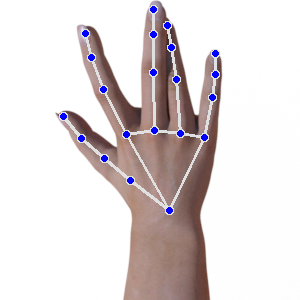

In [ ]:
merged_ds['train'][0]['annotated']

In [ ]:
merged_ds

DatasetDict({
    train: Dataset({
        features: ['raw', 'label', 'image', 'src', 'annotated', 'landmarks'],
        num_rows: 9170
    })
    test: Dataset({
        features: ['raw', 'label', 'image', 'src', 'annotated', 'landmarks'],
        num_rows: 2035
    })
})

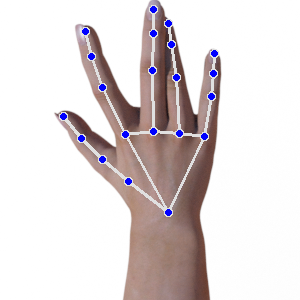

In [ ]:
merged_ds['train'][1]['annotated']

In [ ]:
# !huggingface-cli login
merged_ds.push_to_hub("conjunct/rps_dataset")

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/3057 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

Map:   0%|          | 0/3057 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

Map:   0%|          | 0/3056 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2035 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/conjunct/rps_dataset/commit/e2580abea9278b1f6af917739c81700eb83e48a3', commit_message='Upload dataset', commit_description='', oid='e2580abea9278b1f6af917739c81700eb83e48a3', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['paper', 'rock', 'scissors', 'none'], id=None), 'src': ClassLabel(names=['original', 'kaggle', 'blank'], id=None), 'annotated': {'bytes': Value(dtype='binary', id=None), 'path': Value(dtype='null', id=None)}, 'landmarks': Value(dtype='string', id=None), 'pca': Value(dtype='null', id=None)}
# {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['paper', 'rock', 'scissors', 'none'], id=None), 'src': ClassLabel(names=['original', 'kaggle', 'blank'], id=None), 'annotated': Image(decode=True, id=None), 'landmarks': Value(dtype='string', id=None), 'pca': Value(dtype='null', id=None)}

In [ ]:
ds_v2 = load_dataset("conjunct/rps_dataset")

Generating train split:   0%|          | 0/9170 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2035 [00:00<?, ? examples/s]

## Retry joint addition - with nondeterminism fix

In [ ]:
joint_ds['train'][2520]['annotated']

In [ ]:
prev_ds['train'][2524]['annotated']

By inspection, look at all the cases mediapipe does not give annotation

In [ ]:
for i in range(3998):
    joint_present = joint_ds['train'][i]['annotated']
    prev_present = prev_ds['train'][i]['annotated']
    if not joint_present or not prev_present:
        print(f"{i}",end='')
        if joint_present:
            print("prev")
        elif prev_present:
            print("ratio-fix")
        else:
            print("both")

2520both
2524prev
2525prev
2549ratio-fix
2565prev
2566prev
2574prev
2575prev
2592both
2613both
2614prev
2649prev
2680both
2706both
2709ratio-fix
2710ratio-fix
2727both
2755both
2760ratio-fix
2761prev
2788ratio-fix
2789ratio-fix
2790ratio-fix
2806ratio-fix
2807ratio-fix
2855prev
2856both
2857prev
2870both
2889both
2917both
2918prev
2920both
2921ratio-fix
2954ratio-fix
2974ratio-fix
2986prev
2987prev
2989ratio-fix
2994both
2996prev
3004ratio-fix
3005prev
3022prev
3028both
3029both
3058prev
3072prev
3074both
3079both
3080both
3104prev
3110prev
3113prev
3119both
3131both
3132prev
3133prev
3145prev
3185ratio-fix
3186ratio-fix
3191both
3202prev
3206prev
3207prev
3211prev
3237prev
3282ratio-fix
3283prev
3300prev
3303both
3304prev
3305prev
3359prev
3360both
3392both
3407both
3408prev
3418prev
3419prev
3422both
3423prev
3424prev
3430both
3433ratio-fix
3445both
3462prev
3473both
3476prev
3477both
3482both
3483both
3484prev
3485ratio-fix
3511ratio-fix
3521both
3536both
3565ratio-fix
3566prev
3567

It looks like the aspect ratio fix improved mediapipe performance (63 misses before --> 33 misses after)

# Add better landmark data

In [ ]:
#Utility from Henry
from scipy.spatial.distance import euclidean
import numpy as np
import re
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def parse_landmarks(landmarks_str):
    matches = re.findall(r'landmark \{\s*x: ([e\d.-]+)\s*y: ([e\d.-]+)\s*z: ([e\d.-]+)\s*\}', landmarks_str)
    landmarks = [(float(x), float(y), float(z)) for x, y, z in matches]
    return landmarks

def calculate_distances(landmarks):
    wrist = landmarks[0]
    fingertips_indexes = [4, 8, 12, 16]
    distances = [euclidean(wrist, landmarks[i]) for i in fingertips_indexes]
    return distances

In [ ]:
# fixer method that converts the string
# credit to Henry for the regex
def _hf_convert_parse_landmarks(batch):
    batch['landmarks_old'] = batch['landmarks']
    batch['landmarks'] = [(parse_landmarks(x) if x else []) for x in batch['landmarks']]
    return batch

In [ ]:
add_col(merged_ds, 'landmarks_old')

In [ ]:
merged_jointly_ds = merged_ds.map(_hf_convert_parse_landmarks, batched=True, batch_size=8)

Map:   0%|          | 0/9170 [00:00<?, ? examples/s]

Map:   0%|          | 0/2035 [00:00<?, ? examples/s]

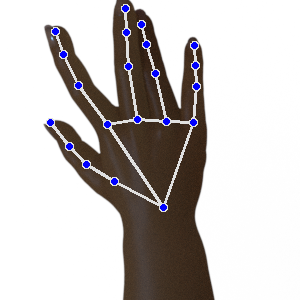

In [ ]:
merged_jointly_ds['train'][127]['annotated']

In [ ]:
merged_jointly_ds['train'][4100]['landmarks']

[[0.8842973709106445, 0.49635595083236694, -1.312354925175896e-06],
 [0.7991530895233154, 0.6776670217514038, 0.019736090674996376],
 [0.6801528930664062, 0.7517204880714417, 0.03246821463108063],
 [0.5807977318763733, 0.736535370349884, 0.03818625584244728],
 [0.5288823246955872, 0.6954299211502075, 0.04446709528565407],
 [0.4817328453063965, 0.6865244507789612, 0.05600724741816521],
 [0.5087334513664246, 0.7145547270774841, 0.07664082944393158],
 [0.5697369575500488, 0.7013422250747681, 0.07677215337753296],
 [0.6147381067276001, 0.6815734505653381, 0.07335875183343887],
 [0.4564249515533447, 0.5792583227157593, 0.03889530152082443],
 [0.4956498444080353, 0.6157197952270508, 0.07412584871053696],
 [0.5592073202133179, 0.6154533624649048, 0.0688900500535965],
 [0.6090183854103088, 0.6013281941413879, 0.057064734399318695],
 [0.47511494159698486, 0.47997981309890747, 0.024344678968191147],
 [0.5052573084831238, 0.5262722969055176, 0.04973098263144493],
 [0.5640593767166138, 0.530126452

In [ ]:
print(merged_jointly_ds['train'][4100]['landmarks_old']) # old format

[landmark {
  x: 0.8842973709106445
  y: 0.49635595083236694
  z: -1.312354925175896e-06
}
landmark {
  x: 0.7991530895233154
  y: 0.6776670217514038
  z: 0.019736090674996376
}
landmark {
  x: 0.6801528930664062
  y: 0.7517204880714417
  z: 0.03246821463108063
}
landmark {
  x: 0.5807977318763733
  y: 0.736535370349884
  z: 0.03818625584244728
}
landmark {
  x: 0.5288823246955872
  y: 0.6954299211502075
  z: 0.04446709528565407
}
landmark {
  x: 0.4817328453063965
  y: 0.6865244507789612
  z: 0.05600724741816521
}
landmark {
  x: 0.5087334513664246
  y: 0.7145547270774841
  z: 0.07664082944393158
}
landmark {
  x: 0.5697369575500488
  y: 0.7013422250747681
  z: 0.07677215337753296
}
landmark {
  x: 0.6147381067276001
  y: 0.6815734505653381
  z: 0.07335875183343887
}
landmark {
  x: 0.4564249515533447
  y: 0.5792583227157593
  z: 0.03889530152082443
}
landmark {
  x: 0.4956498444080353
  y: 0.6157197952270508
  z: 0.07412584871053696
}
landmark {
  x: 0.5592073202133179
  y: 0.6154533

In [ ]:
calculate_distances(merged_jointly_ds['train'][400]['landmarks'])

[0.49780257941879646,
 0.8202962243732164,
 0.7621013011626828,
 0.696038512012864]

# Add PCA (working)

In [ ]:
from datasets import load_dataset
#mediapipe dependencies
# import mediapipe as mp

#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import shutil
import os

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256), # (32, 256)),

    # transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomInvert(p=1),
    transforms.PILToTensor(),

])

In [ ]:
import numpy as np
import os

# Define the shape of the array based on your data
shape = (len(merged_jointly_ds['train']), 65536)

# Create a memory-mapped array with the desired shape
mmapped_array = np.memmap('mmapped_array.dat', dtype='float32', mode='w+', shape=shape)

# Flatten and write tensors to the memory-mapped array
for i, tensor in enumerate(merged_jointly_ds['train']['image']):
    mmapped_array[i] = transform(tensor).flatten()

# Delete the memmap instance to close the file (this does not delete the data on disk)
del mmapped_array

# When you want to read the array from disk
mmapped_array = np.memmap('mmapped_array.dat', dtype='float32', mode='r', shape=shape)

In [ ]:
# Define the shape of the array based on your data
shape = (len(merged_jointly_ds['test']), 65536)

# Create a memory-mapped array with the desired shape
mmapped_array_test = np.memmap('mmapped_array_test.dat', dtype='float32', mode='w+', shape=shape)

# Flatten and write tensors to the memory-mapped array
for i, tensor in enumerate(merged_jointly_ds['test']['image']):
    mmapped_array_test[i] = transform(tensor).flatten()

# Delete the memmap instance to close the file (this does not delete the data on disk)
del mmapped_array_test

# When you want to read the array from disk
mmapped_array_test = np.memmap('mmapped_array_test.dat', dtype='float32', mode='r', shape=shape)

In [ ]:
mean = np.mean(mmapped_array, axis=0)
std_dev = np.std(mmapped_array, axis=0)

In [ ]:
# Create a memory-mapped array for the standardized data
standardized_mmap = np.memmap('standardized_mmap.dat', dtype='float32', mode='w+', shape=shape)

# Standardize the data in chunks to avoid running out of memory
chunk_size = 1000  # Adjust this value based on your available memory
num_chunks = len(mmapped_array) // chunk_size

for i in range(num_chunks):
    chunk = mmapped_array[i*chunk_size:(i+1)*chunk_size]
    standardized_mmap[i*chunk_size:(i+1)*chunk_size] = (chunk - mean) / std_dev

# Don't forget to handle the last chunk if it's smaller than chunk_size
if len(mmapped_array) % chunk_size != 0:
    chunk = mmapped_array[num_chunks*chunk_size:]
    standardized_mmap[num_chunks*chunk_size:] = (chunk - mean) / std_dev

# Delete the memmap instances to close the files (this does not delete the data on disk)
del standardized_mmap

# When you want to read the arrays from disk
standardized_mmap = np.memmap('standardized_mmap.dat', dtype='float32', mode='r', shape=shape)

In [ ]:
# Create a memory-mapped array for the standardized data
standardized_mmap_test = np.memmap('standardized_mmap_test.dat', dtype='float32', mode='w+', shape=shape)


# Standardize the data in chunks to avoid running out of memory
chunk_size = 1000  # Adjust this value based on your available memory
num_chunks = len(mmapped_array_test) // chunk_size

for i in range(num_chunks):
    chunk = mmapped_array_test[i*chunk_size:(i+1)*chunk_size]
    standardized_mmap_test[i*chunk_size:(i+1)*chunk_size] = (chunk - mean) / std_dev

# Don't forget to handle the last chunk if it's smaller than chunk_size
if len(mmapped_array_test) % chunk_size != 0:
    chunk = mmapped_array_test[num_chunks*chunk_size:]
    standardized_mmap_test[num_chunks*chunk_size:] = (chunk - mean) / std_dev

# Delete the memmap instances to close the files (this does not delete the data on disk)
del standardized_mmap_test

# When you want to read the arrays from disk
standardized_mmap_test = np.memmap('standardized_mmap_test.dat', dtype='float32', mode='r', shape=shape)

In [ ]:
!ls -lh

total 4.5G
-rw-r--r-- 1 root root 2.3G Apr 21 02:27 mmapped_array.dat
drwxr-xr-x 1 root root 4.0K Apr 18 13:25 sample_data
-rw-r--r-- 1 root root 2.3G Apr 21 02:29 standardized_mmap.dat


0.9 variance explained at 85 components
0.95 variance explained at 378 components
0.975 variance explained at 1007 components
0.99 variance explained at 2133 components
0.999 variance explained at 4883 components


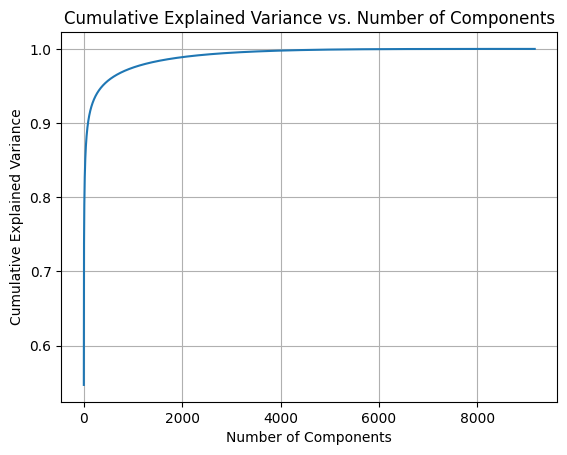

In [ ]:
# Create PCA object
pca = PCA()

# Fit PCA on your data
pca.fit(standardized_mmap)

# Plot cumulative variance explained
axis = np.cumsum(pca.explained_variance_ratio_)
found = 0
for i in range(len(axis)):
  if found == 0 and axis[i] > 0.9:
    print(f'0.9 variance explained at {i} components')
    found += 1
  if found == 1 and axis[i] > 0.95:
    print(f'0.95 variance explained at {i} components')
    found += 1
  if found == 2 and axis[i] > 0.975:
    print(f'0.975 variance explained at {i} components')
    found += 1
  if found == 3 and axis[i] > 0.99:
    print(f'0.99 variance explained at {i} components')
    found += 1
  if found == 4 and axis[i] > 0.999:
    print(f'0.999 variance explained at {i} components')
    found += 1

plt.plot(axis)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
!ls -lh

total 4.5G
-rw-r--r-- 1 root root 2.3G Apr 21 04:36 mmapped_array.dat
-rw-r--r-- 1 root root    0 Apr 21 04:36 pca_4883.pkl
drwxr-xr-x 1 root root 4.0K Apr 18 13:25 sample_data
-rw-r--r-- 1 root root 2.3G Apr 21 03:52 standardized_mmap.dat


In [ ]:
pca_4883 = PCA(n_components=4883).fit(standardized_mmap)

In [ ]:
import time
start = time.time()

transformed_data_4883 = pca_4883.transform(standardized_mmap)
end = time.time()
print("Time for 4883:", end - start)


Time for 4883: 95.49805068969727


In [ ]:
start = time.time()

transformed_data_4883_test = pca_4883.transform(standardized_mmap_test)
end = time.time()
print("Time for 4883:", end - start)

Time for 4883: 22.343729496002197


In [ ]:
import pickle as pk
pk.dump(pca_4883, open("pca_4883.pkl","wb"))

In [ ]:
!cp pca_4883.pkl pca_save.pkl

In [ ]:
import pickle as pk
with open("pca_4883.pkl","rb") as f:
    pca_4883 = pk.load(f)

In [ ]:
!ls -lh

total 5.7G
-rw-r--r-- 1 root root 2.3G Apr 21 03:51 mmapped_array.dat
-rw-r--r-- 1 root root 1.2G Apr 21 04:24 pca_4883.pkl
drwxr-xr-x 1 root root 4.0K Apr 18 13:25 sample_data
-rw-r--r-- 1 root root 2.3G Apr 21 03:52 standardized_mmap.dat


In [ ]:
transformed_data_4883[0]

array([-2.76970520e+02, -1.74311619e+01,  4.67863846e+01, ...,
        2.49618649e-01, -1.09852456e-01, -1.40440697e-02], dtype=float32)

In [ ]:
pca_4883.__dict__

{'n_components': 4883,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'n_features_in_': 65536,
 '_fit_svd_solver': 'randomized',
 'mean_': array([-9.6261310e-06,  1.4620363e-05, -1.2689952e-05, ...,
        -1.3482161e-05,  1.1201350e-05, -2.0204565e-05], dtype=float32),
 'n_samples_': 9170,
 'components_': array([[-0.00463294, -0.00464075, -0.00464439, ..., -0.00463681,
         -0.00463582, -0.00463486],
        [-0.00261404, -0.00260343, -0.00260343, ..., -0.00167846,
         -0.0016954 , -0.00168192],
        [-0.00193095, -0.00197812, -0.0020195 , ...,  0.00480692,
          0.00475259,  0.00470776],
        ...,
        [ 0.00177228,  0.00114712,  0.00530833, ..., -0.00216125,
         -0.00401472, -0.00273602],
        [-0.0022948 ,  0.00196016, -0.00146972, ..., -0.00578019,
         -0.00078371, -0.00228726],
        [ 0.00059408,  0.00010813, 

In [ ]:
with np.printoptions(threshold=np.inf):
    print(valn)

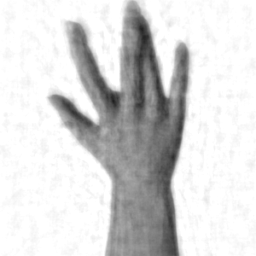

In [ ]:
reconstitute(transformed_data_4883[0], 500)

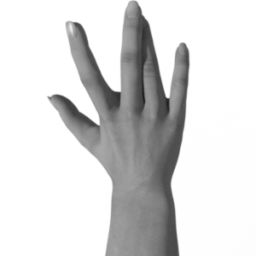

In [ ]:
toImage(transform(merged_jointly_ds['train'][0]['image']))

In [ ]:
orig = transform(merged_jointly_ds['train'][0]['image']).flatten()

In [ ]:
with np.printoptions(threshold=np.inf):
    print(orig.numpy())

In [5]:
toImage = transforms.Compose([
    transforms.ToPILImage(),
])

# number of components to use in reconstruction
# num_components = 106

# which image to compare with its reconstruction
# image_num = 5

# components = pca_2192.components_ # [0:num_components,]
# # components = components.reshape(num_components, -1)

# proj = transformed_data_2192 # [:, 0:num_components]
# proj = proj.reshape(-1, 2192)

# recon = np.dot(proj, components) + pca.mean_
# recon = recon.reshape((-1, 256, 256, 1))

# img = toImage(recon[image_num])
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# img2 = ds_v2_shuffled['train']['image'][image_num]
# plt.imshow(img2)
# plt.axis('off')
# plt.show()

In [ ]:
def _hf_add_pca_train(batch, indices):
    batch['pca'] = [transformed_data_4883[i] for i in indices]
    return batch
def _hf_add_pca_test(batch, indices):
    batch['pca'] = [transformed_data_4883_test[i] for i in indices]
    return batch
pca_enriched_train = merged_jointly_ds['train'].map(_hf_add_pca_train, batched=True, batch_size=32, with_indices=True)
pca_enriched_test = merged_jointly_ds['test'].map(_hf_add_pca_test, batched=True, batch_size=32, with_indices=True)

Map:   0%|          | 0/9170 [00:00<?, ? examples/s]

Map:   0%|          | 0/2035 [00:00<?, ? examples/s]

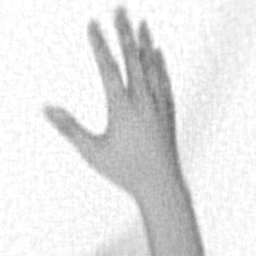

In [ ]:
reconstitute(pca_enriched_test[0]['pca'], 2000)

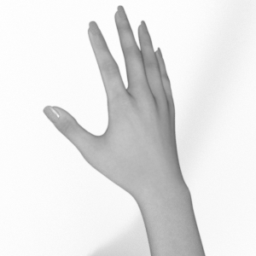

In [ ]:
toImage(transform(pca_enriched_test[0]['image']))

In [ ]:
from datasets import DatasetDict
pca_enriched = DatasetDict({
    'train': pca_enriched_train,
    'test': pca_enriched_test
})

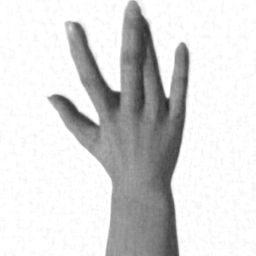

In [ ]:
reconstitute(pca_enriched['train'][0]['pca'], 2000)

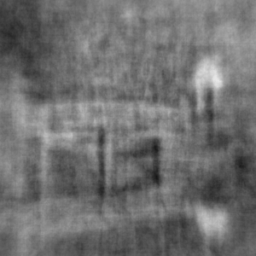

In [ ]:
reconstitute(pca_enriched['train'][7000]['pca'], 500)

# Examining the data

In [ ]:
for i in range(3998):
    if len(features[i]) != 21:
        print(f"{i}: {len(features[i])}")

0: 21
1: 21
2: 21
3: 21
4: 21
5: 21
6: 21
7: 21
8: 21
9: 21
10: 21
11: 21
12: 21
13: 21
14: 21
15: 21
16: 21
17: 21
18: 21
19: 21
20: 21
21: 21
22: 21
23: 21
24: 21
25: 21
26: 21
27: 21
28: 21
29: 21
30: 21
31: 21
32: 21
33: 21
34: 21
35: 21
36: 21
37: 21
38: 21
39: 21
40: 21
41: 21
42: 21
43: 21
44: 21
45: 21
46: 21
47: 21
48: 21
49: 21
50: 21
51: 21
52: 21
53: 21
54: 21
55: 21
56: 21
57: 21
58: 21
59: 21
60: 21
61: 21
62: 21
63: 21
64: 21
65: 21
66: 21
67: 21
68: 21
69: 21
70: 21
71: 21
72: 21
73: 21
74: 21
75: 21
76: 21
77: 21
78: 21
79: 21
80: 21
81: 21
82: 21
83: 21
84: 21
85: 21
86: 21
87: 21
88: 21
89: 21
90: 21
91: 21
92: 21
93: 21
94: 21
95: 21
96: 21
97: 21
98: 21
99: 21
100: 21
101: 21
102: 21
103: 21
104: 21
105: 21
106: 21
107: 21
108: 21
109: 21
110: 21
111: 21
112: 21
113: 21
114: 21
115: 21
116: 21
117: 21
118: 21
119: 21
120: 21
121: 21
122: 21
123: 21
124: 21
125: 21
126: 21
127: 21
128: 21
129: 21
130: 21
131: 21
132: 21
133: 21
134: 21
135: 21
136: 21
137: 21
138: 2

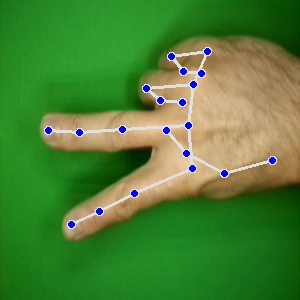

In [ ]:
prev_ds['train'][3833]['annotated']

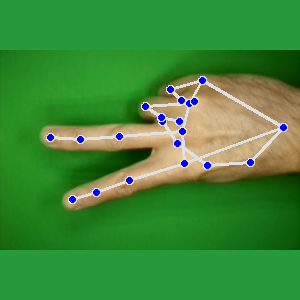

In [ ]:
merged_jointly_ds['train'][3833]['annotated']

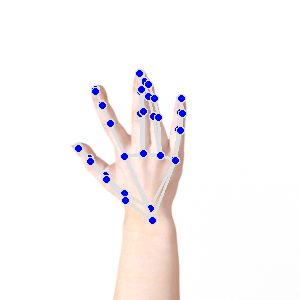

In [ ]:
merged_jointly_ds['train'][360]['annotated']

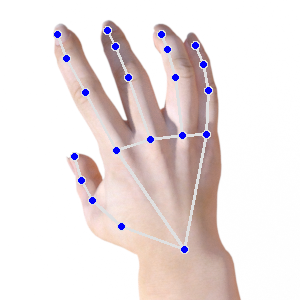

In [ ]:
merged_jointly_ds['train'][396]['annotated']

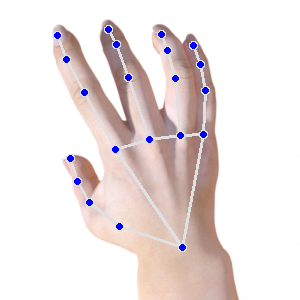

In [ ]:
merged_jointly_ds['train'][397]['annotated']

In [ ]:
image_numpy(ds_v3['train'][128]['image'])

In [ ]:
with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:
  # train
    image = ds_v3['train'][128]['image']
    image_np = image_numpy(image)

    results = hands.process(image_np)
    if results.multi_hand_landmarks:
        for num, hand in enumerate(results.multi_hand_landmarks): # loops however many hands are in the photo, hand is the landmarks, num is hand number
          mp_drawing.draw_landmarks(image_np, hand, mp_hands.HAND_CONNECTIONS) # draw joints onto image

        joint_url = './examination/hands.png'
        landmark_url = './examination/landmark'

        Image.fromarray(image_np).save(joint_url, format='PNG')
        with open(landmark_url, 'w') as file:
          file.write(str(results.multi_hand_landmarks))
    else:
        print("Warning: nothing for ", 128  )




  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [254 254 254]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [254 254 254]
  [253 253 253]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [253 253 253]
  [253 253 253]]]


# Save to hub

In [ ]:
# !huggingface-cli login
pca_enriched.push_to_hub("conjunct/rps_annotated")

Uploading the dataset shards:   0%|          | 0/6 [00:00<?, ?it/s]

Map:   0%|          | 0/1529 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Map:   0%|          | 0/1529 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Map:   0%|          | 0/1528 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Map:   0%|          | 0/1528 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Map:   0%|          | 0/1528 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Map:   0%|          | 0/1528 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1018 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Map:   0%|          | 0/1017 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/832 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/conjunct/rps_annotated/commit/92997da7752a134e68d51beb97b0d08ecabfc8a7', commit_message='Upload dataset', commit_description='', oid='92997da7752a134e68d51beb97b0d08ecabfc8a7', pr_url=None, pr_revision=None, pr_num=None)

Try lowres

In [ ]:
orig_components = pca_4883.components_

In [ ]:
comp_lowres = orig_components.astype(np.float16)

In [ ]:
pca_4883.components_ = comp_lowres

In [ ]:
with open("pca_lowres.pkl", 'wb') as f:
    pk.dump(pca_4883, f)

In [ ]:
!ls -lh

total 9.7G
-rw-r--r-- 1 root root 2.3G Apr 21 04:36 mmapped_array.dat
-rw-r--r-- 1 root root 509M Apr 21 05:24 mmapped_array_test.dat
-rw-r--r-- 1 root root 1.2G Apr 21 05:01 pca_4883.pkl
-rw-r--r-- 1 root root 611M Apr 21 06:10 pca_lowres.pkl
-rw-r--r-- 1 root root 1.2G Apr 21 05:01 pca_save.pkl
drwxr-xr-x 1 root root 4.0K Apr 18 13:25 sample_data
-rw-r--r-- 1 root root 2.3G Apr 21 04:38 standardized_mmap.dat
-rw-r--r-- 1 root root 509M Apr 21 05:29 standardized_mmap_test.dat
-rw-r--r-- 1 root root 1.2G Apr 21 05:42 weights.npy


In [ ]:
from google.colab import files
files.download('pca_lowres.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>